In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import *
import cvxopt as cv
from numpy.random import *
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap

In [2]:
# irisデータ準備
iris = load_iris()
x_1 = iris.data[iris.target==0, 0:2]
x_2 = iris.data[iris.target==1, 0:2]
x = np.vstack((x_1, x_2))

label_1 = [1 for i in range(x_1.shape[0])]
label_2 = [-1 for i in range(x_2.shape[0])]
label = label_1 + label_2

x_train, x_test, y_train, y_test = train_test_split(x, label, test_size=0.2, random_state=2)

In [3]:
# SVM 学習
## パラメータ初期化
C = 1.0
kernel = rbf_kernel
eps = 10**(-7)

## 最適化
X = x_train
y = np.array(y_train)

K_gram = kernel(X)
N = len(X)
Y = np.array( [[y[i] * y[j] for j in range(N)] for i in range(N)] )
P = cv.matrix( K_gram * Y )

q = cv.matrix( -np.ones(N) )
G = cv.matrix( np.r_[np.identity(N), -np.identity(N)] )
h = cv.matrix( np.r_[C*np.ones(N).T, np.zeros(N).T] )

A = cv.matrix( np.array([y], dtype="double") )
b = cv.matrix(0.1)

sol = cv.solvers.qp(P=P, q=q, G=G, h=h, A=A, b=b)

## サポートベクターの抽出
index_list = list(filter(lambda x: sol['x'][x] > eps , range(N)))
w = np.array(sol['x'])[index_list].reshape(len(index_list)) * y[index_list]
support_vector = X[index_list]

## バイアスの計算
tmp_list = []
for i in index_list:
    tmp = 0
    for j in index_list:
        tmp += (sol['x'][j] * y[j] * K_gram[i][j])
    tmp_list.append(y[i]-tmp)
b = np.mean(tmp_list)

     pcost       dcost       gap    pres   dres
 0: -9.3302e+00 -1.2080e+02  4e+02  2e+00  5e-16
 1: -5.2020e+00 -5.7579e+01  5e+01  1e-02  7e-16
 2: -8.6293e+00 -1.7669e+01  9e+00  2e-03  5e-16
 3: -1.0848e+01 -1.3920e+01  3e+00  6e-04  6e-16
 4: -1.1847e+01 -1.2310e+01  5e-01  5e-05  6e-16
 5: -1.2010e+01 -1.2085e+01  8e-02  8e-06  6e-16
 6: -1.2039e+01 -1.2043e+01  3e-03  2e-07  7e-16
 7: -1.2041e+01 -1.2041e+01  6e-05  3e-09  8e-16
 8: -1.2041e+01 -1.2041e+01  6e-07  3e-11  8e-16
Optimal solution found.


In [4]:
# SVM 推論
pred_y = np.dot(np.array([w]), kernel(x_test, support_vector).T) + b
pred_y = pred_y.reshape(len(x_test))
pred_label = np.array([1 if pred > 0 else -1 for pred in pred_y])
print('acc = {}'.format(accuracy_score(y_test, pred_label)))

acc = 1.0


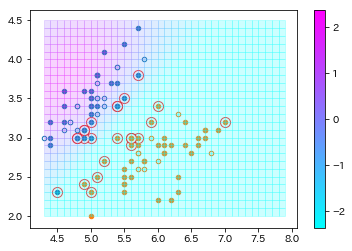

In [6]:
# 図の作成
x_range = [ min(iris.data[:, 0]), max(iris.data[:, 0]) ]
y_range = [ min(iris.data[:, 1]), max(iris.data[:, 1]) ]

grid_size = 0.1
x_list = np.arange(x_range[0], x_range[1], grid_size)
y_list = np.arange(y_range[0], y_range[1], grid_size)

max_m = np.linalg.norm( np.array([x_range[0]/2, y_range[0]/2]) - np.array([x_range[0], y_range[0]]) )

plt.figure()
for xi in x_list:
    for yi in y_list:
        pred_s = ( float( np.dot(np.array([w]), kernel(np.array([[xi, yi]]), support_vector).T) + b ) )
        
        color = cm.cool(pred_s / max_m)
        
        testx = [xi, xi+grid_size, xi+grid_size, xi]
        testy = [yi, yi, yi+grid_size, yi+grid_size]
        plt.fill(testx,testy,color=color,alpha=0.2)

plt.scatter(support_vector[:, 0], support_vector[:, 1], marker='o', alpha=0.8, c='white', edgecolors="red", linewidths="1", s=100)
plt.scatter(iris.data[iris.target==0, 0], iris.data[iris.target==0, 1], s=20)
plt.scatter(iris.data[iris.target==1, 0], iris.data[iris.target==1, 1], s=20)
plt.scatter(x_test[:, 0], x_test[:, 1], c="white", s=5, edgecolors="white")

norm = Normalize(vmin=-max_m, vmax=max_m)
cmap = get_cmap('cool')
mappable = ScalarMappable(cmap=cmap, norm=norm)
mappable._A = []
plt.colorbar(mappable)
plt.show()